Shape: (6685, 308)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Columns: 308 entries, PUMFID to VERDATE
dtypes: float64(1), int64(306), object(1)
memory usage: 15.7+ MB


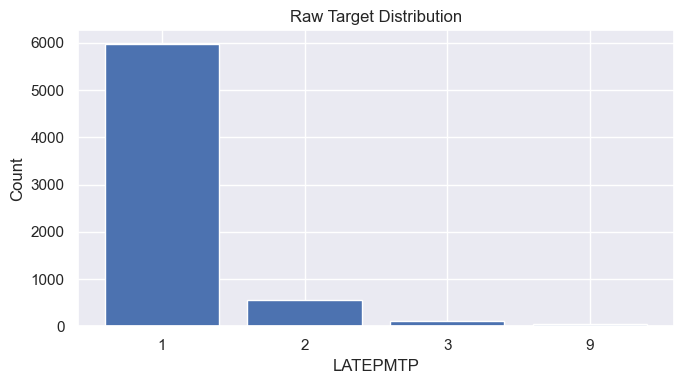

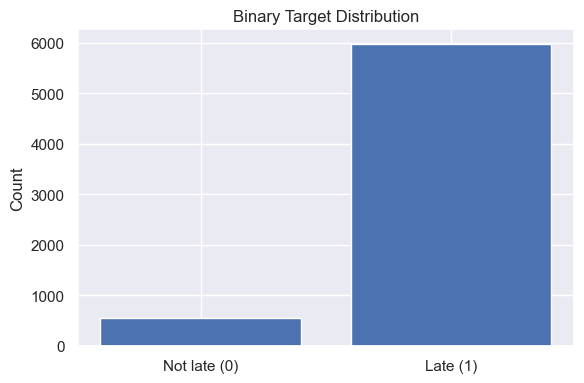

Late payment rate: 91.52 %
(6518, 26)


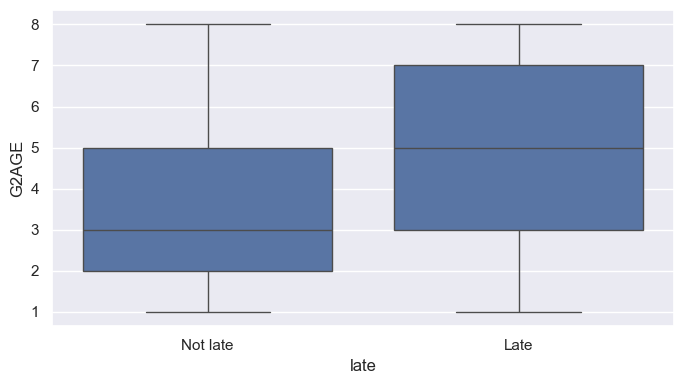

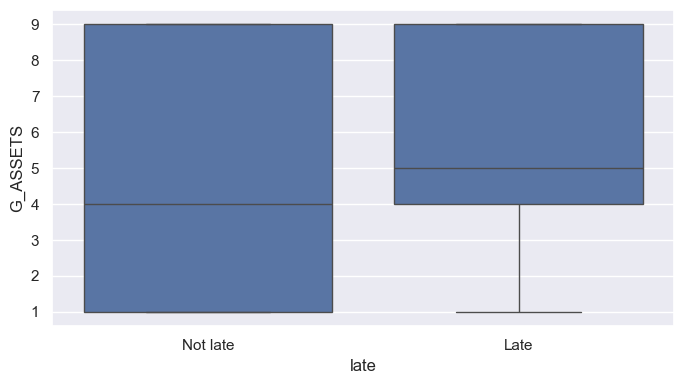

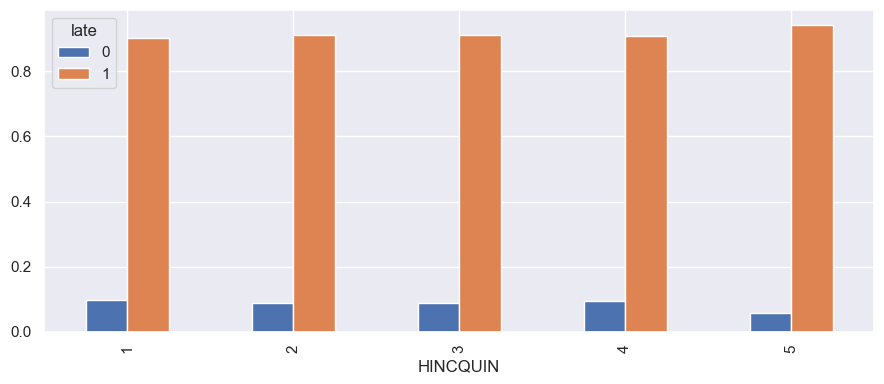

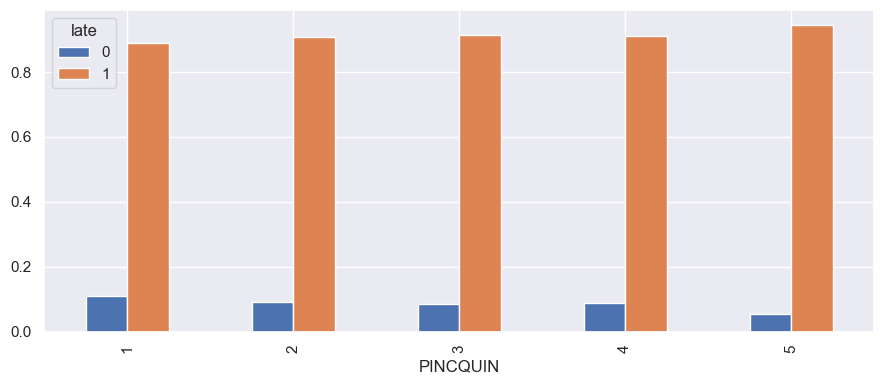

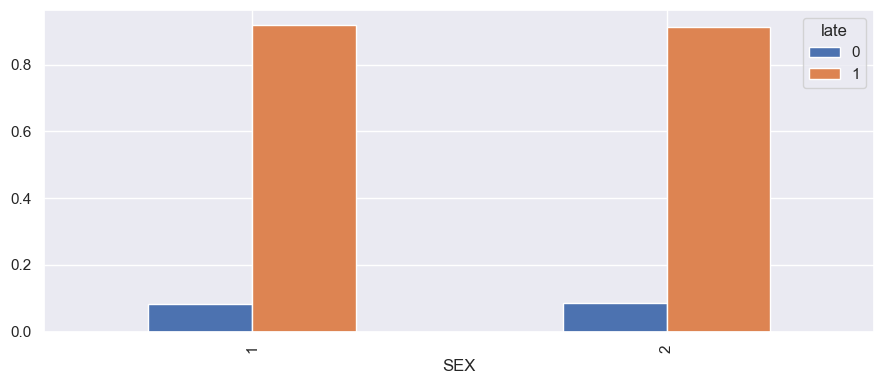

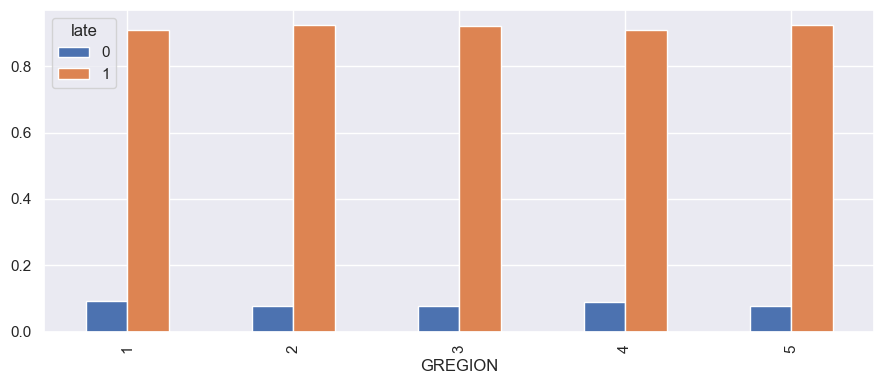

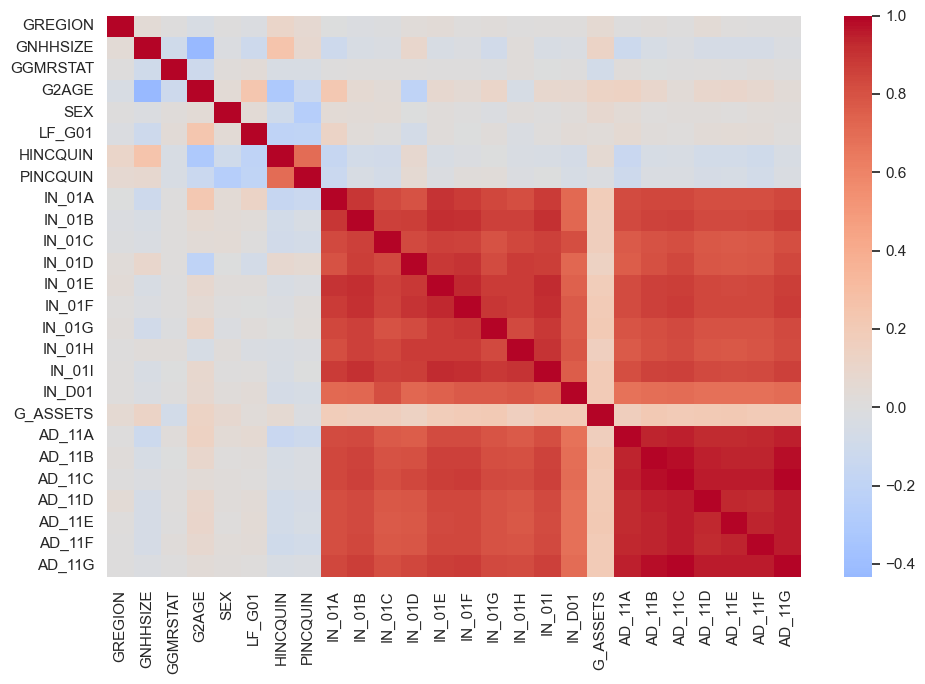

Rows with valid target: 6518
Late payment rate: 91.52 %


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import seaborn as sns
    sns.set_theme()
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

df = pd.read_csv("../data/cfcs_2014.csv")
print("Shape:", df.shape)
df.head()
df.sample(5, random_state=42)
df.info()
df.describe().T.head(15)
target = "LATEPMTP"
df[target].value_counts(dropna=False).head(20)
plt.figure(figsize=(7,4))
vc = df[target].value_counts(dropna=False)
plt.bar(vc.index.astype(str), vc.values)
plt.title("Raw Target Distribution")
plt.xlabel("LATEPMTP")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
y = pd.to_numeric(df[target], errors="coerce").map({1: 1, 2: 0})
y.value_counts(dropna=False)
y_clean = y.dropna().astype(int)

plt.figure(figsize=(6,4))
counts = y_clean.value_counts().sort_index()
plt.bar(["Not late (0)", "Late (1)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Binary Target Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Late payment rate:", round(y_clean.mean()*100, 2), "%")
missing_count = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
missing_table.head(20)

top_missing = missing_table.query("missing_count > 0").head(20).iloc[::-1]

if len(top_missing) > 0:
    plt.figure(figsize=(9,6))
    plt.barh(top_missing.index, top_missing["missing_pct"])
    plt.title("Top Missingness (%)")
    plt.xlabel("Missing %")
    plt.tight_layout()
    plt.show()
features = [
    "GREGION", "GNHHSIZE", "GGMRSTAT", "G2AGE", "SEX",
    "LF_G01", "HINCQUIN", "PINCQUIN",
    "IN_01A", "IN_01B", "IN_01C", "IN_01D", "IN_01E", "IN_01F", "IN_01G", "IN_01H", "IN_01I", "IN_D01",
    "G_ASSETS",
    "AD_11A", "AD_11B", "AD_11C", "AD_11D", "AD_11E", "AD_11F", "AD_11G"
]

existing = [c for c in features if c in df.columns]
data = df[[target] + existing].copy()
data.shape
mask = y.notna()
X = data.drop(columns=[target]).loc[mask].copy()
y2 = y.loc[mask].astype(int)

print(X.shape)
y2.value_counts()
num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols[:10], cat_cols[:10]
def plot_numeric(col):
    tmp = pd.DataFrame({col: X[col], "late": y2})
    plt.figure(figsize=(7,4))
    if HAS_SEABORN:
        sns.boxplot(x="late", y=col, data=tmp)
        plt.xticks([0,1], ["Not late", "Late"])
    else:
        g0 = tmp[tmp["late"]==0][col].dropna()
        g1 = tmp[tmp["late"]==1][col].dropna()
        plt.boxplot([g0, g1], labels=["Not late", "Late"])
    plt.tight_layout()
    plt.show()

def plot_cat(col, top_k=12):
    tmp = pd.DataFrame({col: X[col], "late": y2})
    keep = tmp[col].value_counts().head(top_k).index
    tmp[col] = tmp[col].where(tmp[col].isin(keep), other="Other")
    ct = pd.crosstab(tmp[col], tmp["late"], normalize="index")
    ct.plot(kind="bar", figsize=(9,4))
    plt.tight_layout()
    plt.show()
for c in ["G2AGE", "G_ASSETS"]:
    if c in X.columns:
        plot_numeric(c)

for c in ["HINCQUIN", "PINCQUIN", "SEX", "GREGION"]:
    if c in X.columns:
        plot_cat(c)
if len(num_cols) >= 2:
    corr = X[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(10,7))
    if HAS_SEABORN:
        sns.heatmap(corr, cmap="coolwarm", center=0)
    else:
        plt.imshow(corr.values)
        plt.colorbar()
    plt.tight_layout()
    plt.show()
print("Rows with valid target:", len(y2))
print("Late payment rate:", round(y2.mean()*100, 2), "%")

